In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_parquet('../data/rucphen_precipitation_clean.parquet')

In [2]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()
def show_df(df, start = pd.to_datetime('2020-02-01 08:00:00'), end = pd.to_datetime('2023-11-01 08:00:00')):
    # Define the start and end timestamps
    start_timestamp = start
    end_timestamp = end

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    create_plot(result_df, 'timestamp','Timestamp', 'precipitation','mm', 'Line Plot: Rainfall over time')
    create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')


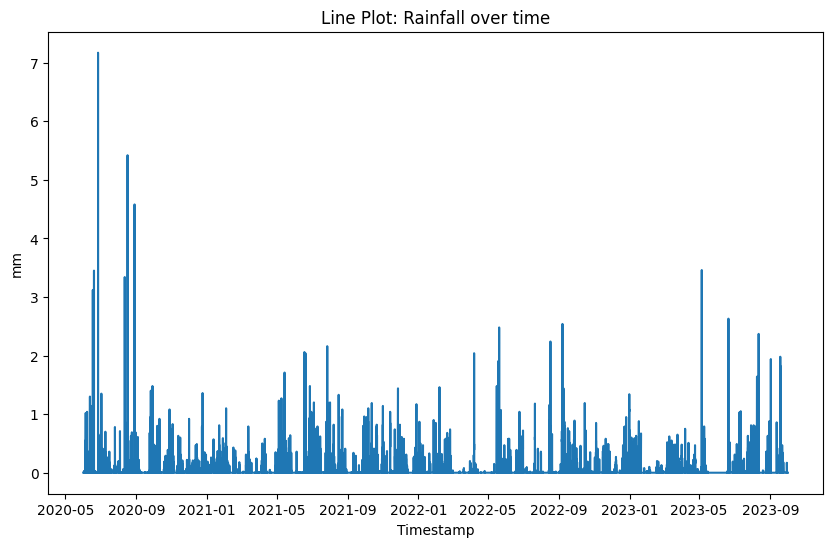

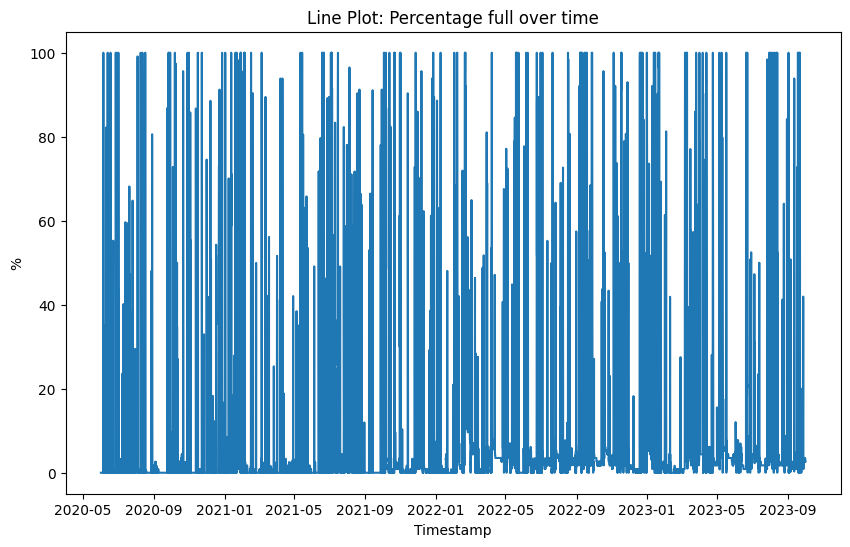

In [3]:
show_df(df, pd.to_datetime('2020-06-01 08:00:00'), pd.to_datetime('2023-10-01 08:00:00'))

/tmp/ipykernel_34533/1151599856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced.fillna(0, inplace=True)


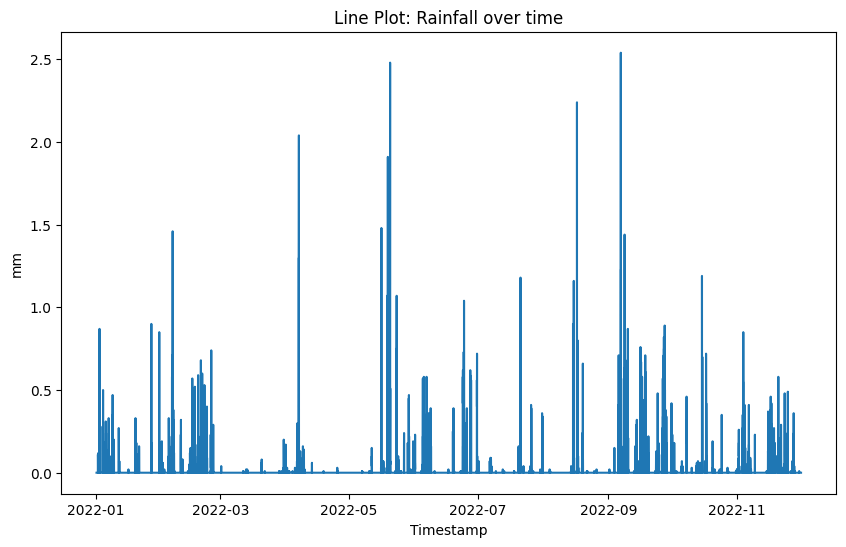

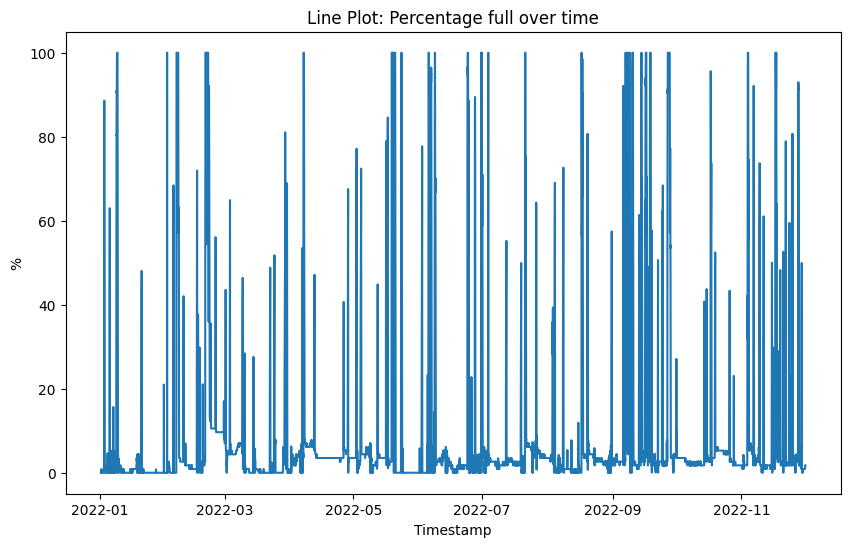

In [4]:
start_timestamp = pd.to_datetime('2022-01-01 08:00:00')
end_timestamp = pd.to_datetime('2022-12-01 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df_reduced = df[mask]
df_reduced.fillna(0, inplace=True)
show_df(df_reduced)

In [5]:
def df_features_of_df(df: pd.DataFrame):
    # Datetime features
    # Extracting features
    print(df)
    df_features = df.copy()
    # df_features['hour'] = df_features['timestamp'].dt.hour
    # df_features['dayofweek'] = df_features['timestamp'].dt.hour
    # df_features['month'] = df_features['timestamp'].dt.hour

    # Define the lags you want
    # precipitation_lags = [1, 2]
    # percentage_lags = [1, 2]

    # df_features['precipitation_20-60'] = df_features['precipitation'].shift(4).rolling(8, min_periods=1).sum() - df_features['precipitation']
    # df_features['percentage_60-120'] = df_features['percentage'].shift(12).rolling(12, min_periods=1).sum() - df_features['percentage']
    # df_features['precipitation_20-90'] = df_features['precipitation'].shift(4).rolling(6, min_periods=1).sum() - df_features['precipitation']

    # Add lag features for 'precipitation'
    # for lag in precipitation_lags:
    #     df_features[f'precipitation_lag_{lag}'] = df_features['precipitation'].shift(lag)

    # # Add lag features for 'percentage'
    # for lag in percentage_lags:
    #     df_features[f'percentage_lag_{lag}'] = df_features['percentage'].shift(lag)

    # Drop rows with NaN values introduced by the lag operation
    df_features.dropna(inplace=True)
    
    # Reset index to integers
    df_features = df_features.reset_index(drop=True)

    return df_features

In [6]:
df_features = df_features_of_df(df_reduced)
df_features.head()

                 timestamp  precipitation  percentage
313409 2022-01-01 08:00:00            0.0       0.000
313410 2022-01-01 08:05:00            0.0       0.000
313411 2022-01-01 08:10:00            0.0       0.000
313412 2022-01-01 08:15:00            0.0       0.000
313413 2022-01-01 08:20:00            0.0       0.000
...                    ...            ...         ...
409004 2022-12-01 07:35:00            0.0       1.754
409005 2022-12-01 07:40:00            0.0       1.754
409006 2022-12-01 07:45:00            0.0       1.754
409007 2022-12-01 07:50:00            0.0       1.754
409008 2022-12-01 07:55:00            0.0       1.754

[95600 rows x 3 columns]


,timestamp,precipitation,percentage
0,2022-01-01 08:00:00,0.0,0.0
1,2022-01-01 08:05:00,0.0,0.0
2,2022-01-01 08:10:00,0.0,0.0
3,2022-01-01 08:15:00,0.0,0.0
4,2022-01-01 08:20:00,0.0,0.0


In [7]:
# Extract features and target from the DataFrame
X = df_features.loc[:, df_features.columns != 'percentage']
X.drop(columns='timestamp', inplace=True)
y = df_features['percentage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Standardize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/tmp/ipykernel_34533/2957457751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns='timestamp', inplace=True)


In [8]:
print("Number of samples in X_train_scaled:", len(X_train_scaled))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in X_test_scaled:", len(X_test_scaled))
print("Number of samples in y_test:", len(y_test))


Number of samples in X_train_scaled: 47800
Number of samples in y_train: 47800
Number of samples in X_test_scaled: 47800
Number of samples in y_test: 47800


In [9]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
# Train SVM Model
model = svm.SVR(kernel= 'linear')

# Assuming X_train_scaled, y_train are already defined
param_grid = {'C': [10, 50, 100], 'gamma': [0.001,0.01, 0.1, 1], 'epsilon': [0.1, 0.2, 0.5]}

# Define scoring using multiple metrics
scoring = {'MSE': make_scorer(mean_squared_error, greater_is_better=False),
           'R2': make_scorer(r2_score)}

# TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring=scoring,refit='R2', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(kernel='linear'), n_jobs=-1,
             param_grid={'C': [10, 50, 100], 'epsilon': [0.1, 0.2, 0.5],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             refit='R2',
             scoring={'MSE': make_scorer(mean_squared_error, greater_is_better=False),
                      'R2': make_scorer(r2_score)})

In [10]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
print(best_model)

{'C': 10, 'epsilon': 0.5, 'gamma': 0.001}
SVR(C=10, epsilon=0.5, gamma=0.001, kernel='linear')


Mean Squared Error: 525.6611068327486
r2: -0.09783015992061017


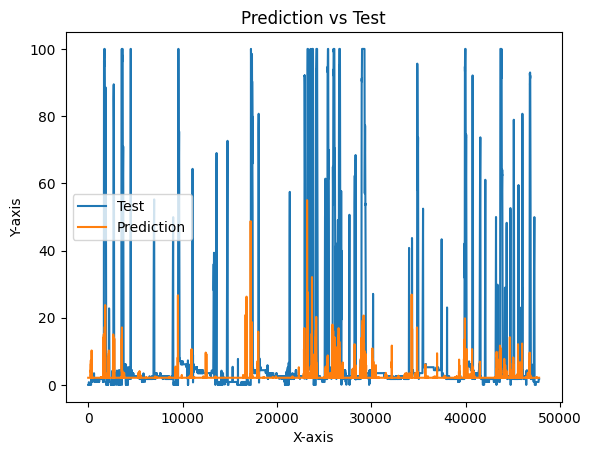

In [11]:
def predict_and_evaluate(y_test, model):
    # Make Predictions
    predictions = best_model.predict(X_test_scaled)
    y_test_converted = y_test.to_numpy()

    # Use np.clip to limit values between 0 and 100
    predictions_clipped = np.clip(predictions, 0, 100)

    # Evaluate the Model
    mse = mean_squared_error(y_test_converted, predictions_clipped)
    print(f'Mean Squared Error: {mse.item()}')

    r2 = r2_score(y_test_converted, predictions_clipped)
    print(f'r2: {r2.item()}')

    # Plotting
    plt.plot(y_test_converted, label='Test')
    plt.plot(predictions_clipped, label='Prediction')

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Prediction vs Test')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

predict_and_evaluate(y_test, best_model)

                 timestamp  percentage
487060 2024-03-02 14:00:00       0.877
487061 2024-03-02 14:05:00       0.877
487062 2024-03-02 14:10:00       0.877
487063 2024-03-02 14:15:00       0.877
487064 2024-03-02 14:20:00       0.877
...                    ...         ...
494857 2024-03-29 18:45:00       2.632
494858 2024-03-29 18:50:00       2.632
494859 2024-03-29 18:55:00       2.632
494860 2024-03-29 19:00:00       2.632
494861 2024-03-29 19:05:00       2.632

[7802 rows x 2 columns]


/tmp/ipykernel_34533/3712327440.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_future.fillna(0, inplace=True)


Mean Squared Error: 525.6611068327486
r2: -0.09783015992061017


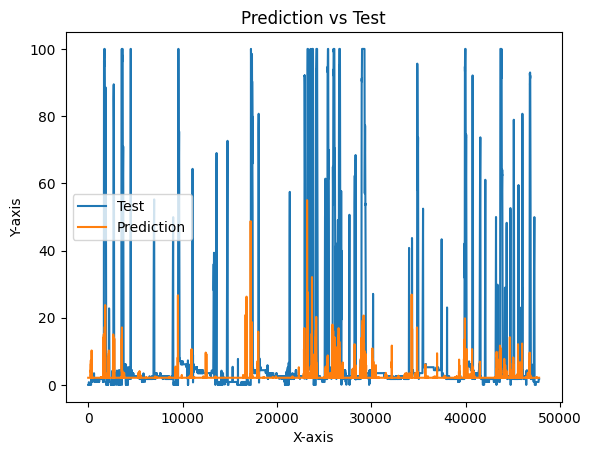

In [12]:
start_timestamp = pd.to_datetime('2023-09-02 14:00:00')
end_timestamp = pd.to_datetime('2023-09-30 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df_future = df[mask]
df_future.fillna(0, inplace=True)

# set every timestamp in merged_df to 6 months later, and put this in a new dataframe
df_future_6_months_later = df_future.copy()
df_future_6_months_later['timestamp'] = df_future_6_months_later['timestamp'] + pd.DateOffset(months=6)
# only give me timestamp and precipitation
df_future_6_months_later = df_future_6_months_later[['timestamp', 'percentage']]
df_features_of_df(df_future_6_months_later)
# show_df(df_future_6_months_later, pd.to_datetime('2024-03-01 14:00:00'), pd.to_datetime('2024-03-30 08:00:00'))
predict_and_evaluate(y_test, best_model)